# Cours apprentissage statistique et réseaux de neurones.
## Master mathématiques appliquées, statistique, Parcours Data Science.
## Frédéric Richard, 2025.
## TP 2. Régression en PyTorch.

L'objectif de ce TP est d'apprendre à utiliser PyTorch pour construire et apprendre des réseaux de neurones. Dans une première partie, on s'intéresse à la régression linéaire que l'on traite avec un perceptron. Puis on étend le modèle de régression à un perceptron multicouche. Pour finir, on traite de la régression logistisque pour un problème de classification. 

### 1. Régression linéaire.


#### 1.1. Données sur le cancer de la prostate.

On s'intéresse au jeu de données téléchargé sur le site kaggle [prostate-cancer-forensic](https://www.kaggle.com/code/noeyislearning/prostate-cancer-forensics?scriptVersionId=212069327). Ces données sont contenues dans le fichier prostate.csv.

Les variables de ce jeu de données sont les suivantes:
- **lcavol** : Logarithme du volume cancéreux (log(volume cancéreux)). Il s'agit d'une mesure de la taille de la tumeur cancéreuse.
- **lweight** : Logarithme du poids de la prostate (log(poids de la prostate)). Cela indique le poids de la glande prostatique.
- **age** : Âge du patient. C'est l'âge de l'individu au moment du diagnostic.
- **lbph** : Logarithme de la quantité d'hyperplasie bénigne de la prostate (log(hyperplasie bénigne de la prostate)). Il s'agit d'une mesure de l'élargissement non cancéreux de la prostate.
- **svi** : Invasion des vésicules séminales (binaire : 0 ou 1). Cela indique si le cancer s'est propagé aux vésicules séminales.
- **lcp** : Logarithme de la pénétration capsulaire (log(pénétration capsulaire)). Cela mesure jusqu'où le cancer s'est propagé dans la capsule prostatique.
- **gleason** : Score de Gleason. C'est un système de classification utilisé pour évaluer l'agressivité du cancer de la prostate en fonction de l'apparence microscopique de la tumeur.
- **pgg45** : Pourcentage des scores de Gleason 4 ou 5. Cela indique la proportion de cellules cancéreuses ayant un score de Gleason de 4 ou 5, qui sont des formes plus agressives de cancer.
- **lpsa** : Logarithme de l'antigène prostatique spécifique (log(PSA)). Le PSA est une protéine produite par la prostate, et des niveaux élevés peuvent indiquer un cancer de la prostate.
- **train** : Indicateur d'entraînement (booléen : True ou False). Cela indique si le point de données fait partie de l'ensemble d'entraînement (True) ou non (False).


Il s'agit d'établir un lien entre la variable lpsa et les autres variables (exceptée train). 


Le fichier peut se charger avec pandas de la manière suivante.

In [135]:
import pandas as pd

# Chargement du jeux de données.
prostate = pd.read_csv('./prostate.csv')

# Informations sur les variables.
prostate.info()

# Visualisation partielle
prostate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
 9   train    97 non-null     bool   
dtypes: bool(1), float64(5), int64(4)
memory usage: 7.0 KB


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,True
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,True
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,True
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,True
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,True


On sépare le jeu de données en un ensemble d'apprentissage et un ensemble de test.

In [136]:
# Création des ensembles d'apprentissage et de test.
train_set = prostate[prostate["train"] == True] 
test_set = prostate[prostate["train"] == False]

Par gérer ces données en Pytorch, on crée des Dataset de PyTorch; voir [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). 

In [137]:
from torch.utils.data import TensorDataset
from torch import Tensor

# Definition des variables de régressions et cible.
x_var = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
y_var = ['lpsa']

# Creation d'un dataset Pytorch.
train_dataset = TensorDataset(Tensor(train_set[x_var].values), Tensor(train_set[y_var].values))
test_dataset = TensorDataset(Tensor(test_set[x_var].values), Tensor(test_set[y_var].values))

print("Taille de l'ensemble d'apprentissage: ", len(train_dataset))
print("Taille de l'ensemble de test: ", len(test_dataset))

Taille de l'ensemble d'apprentissage:  67
Taille de l'ensemble de test:  30


#### 1.2. Création d'un réseau de neurones en PyTorch.

La construction d'un réseau de neurones particulier en PyTorch se fait en héritant la classe Module du package torch.nn et en adaptant le constructeur et la méthode *forward* de cette classe. La définition du constructeur permet de définir les couches et les variables spécifiques du réseau. La méthode forward permet de spécifier les opérations qui conduisent de l'entrée du réseau à sa sortie. Une mise en oeuvre du modèle de régression linéaire est présentée ci-dessous.   

In [138]:
from torch.nn import Module, Linear

class RegressionLineaire(Module):
    def __init__(self, input_dim, output_dim):
        super(RegressionLineaire, self).__init__()
        # Définition des paramètres du modèle.
        self.p = input_dim
        self.k = output_dim
        # Definition de la couche du réseau.
        self.couche_dense = Linear(in_features=self.p, out_features=self.k, bias=True)

    def forward(self, x):
        # Application de la couche dense à l'entrée.
        x = self.couche_dense(x)

        return x

On observe que la régression linéaire est mise en oeuvre au travers d'un perceptron à une seule couche et sans activation.

Après avoir défini le réseau, il faut en créer une instance.

**Exercice**

Pour créer cette instance, compléter le code ci-dessous en spécifiant les paramètres p et k.

In [139]:
p = len(x_var)
k = len(y_var)

# Instanciation du modèle.
modele = RegressionLineaire(p, k)

On peut visualiser la structure du réseau avec la commande print:

In [140]:
print(modele)

RegressionLineaire(
  (couche_dense): Linear(in_features=8, out_features=1, bias=True)
)


On peut également faire un bilan de ses paramètres.

In [141]:
print("Bilan des paramètres du modèle:")
total_param = 0
for nom, param in modele.named_parameters():
    if param.requires_grad:
        print(f"{nom}: {param.numel()}")
        total_param += param.numel()
print(f"Total: {total_param}")

Bilan des paramètres du modèle:
couche_dense.weight: 8
couche_dense.bias: 1
Total: 9


#### 1.2. Apprentissage du modèle.

Après la définition du modèle, nous passons à l'étape d'apprentissage qui va permettre d'estimer les paramètres du modèle.

On commence par choisir la fonction de perte (loss function) et l'algorithme d'optimisation ou optimiseur.

In [142]:
from torch.nn import MSELoss as MSE
from torch.optim import Adam

critere = MSE()
optimiseur = Adam(modele.parameters(), lr=0.001)

Des algorithmes d'optimisation comme Adam fonctionnent à partir de lots (batch). On va définir comment sont chargés ces lots sur les données de la manière suivante.

In [143]:
from torch.utils.data import DataLoader

trainbatch = DataLoader(train_dataset, batch_size=6, shuffle=True)
testbatch = DataLoader(test_dataset, batch_size=1, shuffle=True)

On passe ensuite à l'apprentissage en tant que tel en définissant les époques (epoch).

In [144]:


num_epochs = 100  # Nombre d'époques pour l'entraînement.
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (X, Y) in enumerate(trainbatch):
        # Réinitialisation des gradients
        optimiseur.zero_grad()

        # Passage avant
        outputs = modele(X)
        loss = critere(outputs, Y)

        # Rétropropagation et optimisation
        loss.backward()
        optimiseur.step()

        # Affichage des statistiques de perte
        running_loss += loss.item()

    # Stockage de la perte moyenne pour chaque époque
    epoch_loss = running_loss / len(trainbatch)
    losses.append(epoch_loss)
    
    print(f"[{epoch + 1}] loss = {running_loss / len(trainbatch):.3f}")

[1] loss = 570.133
[2] loss = 442.723


[3] loss = 455.263
[4] loss = 370.988
[5] loss = 343.014
[6] loss = 305.515
[7] loss = 243.939
[8] loss = 215.681
[9] loss = 190.546
[10] loss = 163.728
[11] loss = 149.927
[12] loss = 125.344
[13] loss = 114.572
[14] loss = 92.696
[15] loss = 82.261
[16] loss = 68.554
[17] loss = 58.082
[18] loss = 49.680
[19] loss = 42.544
[20] loss = 41.993
[21] loss = 35.087
[22] loss = 30.679
[23] loss = 22.483
[24] loss = 18.889
[25] loss = 15.970
[26] loss = 14.965
[27] loss = 12.791
[28] loss = 10.213
[29] loss = 8.907
[30] loss = 7.850
[31] loss = 7.030
[32] loss = 6.609
[33] loss = 5.847
[34] loss = 5.389
[35] loss = 5.328
[36] loss = 5.348
[37] loss = 4.766
[38] loss = 4.155
[39] loss = 3.881
[40] loss = 3.845
[41] loss = 3.570
[42] loss = 4.039
[43] loss = 3.489
[44] loss = 3.386
[45] loss = 3.530
[46] loss = 3.121
[47] loss = 3.366
[48] loss = 2.909
[49] loss = 3.239
[50] loss = 2.928
[51] loss = 2.706
[52] loss = 2.874
[53] loss = 2.586
[54] loss = 2.775
[55] loss = 2.470
[56] loss = 2.52

**Exercice**

1. Tracer le graphe du coût en fonction des itérations. 
2. Fixer une itération à partir de laquelle on peut considérer qu'il y a eu convergence de l'algorithme de minimisation. 

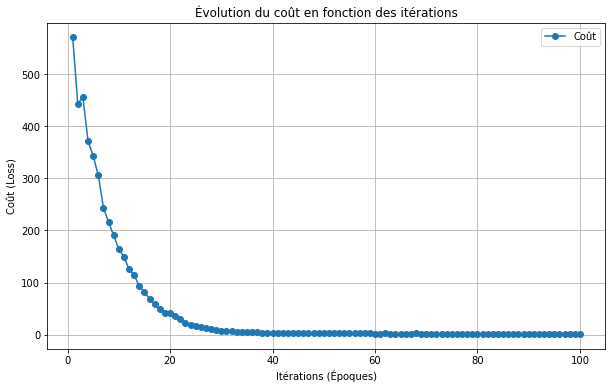

In [145]:
import matplotlib.pyplot as plt

# Tracé du graphe de la perte
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o', label='Coût')
plt.xlabel('Itérations (Époques)')
plt.ylabel('Coût (Loss)')
plt.title('Évolution du coût en fonction des itérations')
plt.legend()
plt.grid(True)
plt.show()

In [146]:
# Détermination de l'itération de convergence
convergence_epoch = next((i + 1 for i in range(1, len(losses)) if abs(losses[i] - losses[i - 1]) < 0.002), None)
print(f"Convergence atteinte à l'époque : {convergence_epoch}")

Convergence atteinte à l'époque : None


#### 1.3. Test du modèle.

On peut appliquer le réseau de neurones sur les données de test: 

In [147]:
from torch import no_grad

with no_grad():
    modele.eval()
    
    # Erreur d'apprentissage.
    loss_train = 0
    for i, (X, Y) in enumerate(trainbatch):
        outputs = modele(X)
        loss = critere(outputs, Y)
        loss_train += loss.item()
    loss_train = loss_train / len(trainbatch)
    
    # Erreur de généralisation.
    loss_test = 0
    for i, (X, Y) in enumerate(testbatch):
        outputs = modele(X)
        loss = critere(outputs, Y)
        loss_test += loss.item()
    loss_test = loss_test / len(testbatch)

print('Train loss :', loss_train)
print('Test loss :', loss_test)

Train loss : 1.456021082897981
Test loss : 1.2893398739994155


**Exercice**


1. Modifier le modèle de départ
    - en changeant les activations (prendre par exemple une activation ReLU),
    - en ajoutant une couche dense.
2. Comparer le premier modèle à ces derniers modèles.

In [148]:
from torch.nn import ReLU

class ModeleAmeliore(Module):
    def __init__(self):
        super(ModeleAmeliore, self).__init__()
        self.couche1 = Linear(8, 16)  # Première couche dense
        self.activation1 = ReLU()    # Activation ReLU
        self.couche2 = Linear(16, 8)  # Deuxième couche dense
        self.activation2 = ReLU()    # Activation ReLU
        self.couche_finale = Linear(8, 1)  # Couche de sortie

    def forward(self, x):
        x = self.activation1(self.couche1(x))
        x = self.activation2(self.couche2(x))
        return self.couche_finale(x)

modele_modifie = ModeleAmeliore()

optimiseur_modifie = Adam(modele_modifie.parameters(), lr=0.001)

In [149]:
num_epochs = 100  # Nombre d'époques pour l'entraînement.
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (X, Y) in enumerate(trainbatch):
        # Réinitialisation des gradients
        optimiseur_modifie.zero_grad()

        # Passage avant
        outputs = modele_modifie(X)
        loss = critere(outputs, Y)

        # Rétropropagation et optimisation
        loss.backward()
        optimiseur_modifie.step()

        # Affichage des statistiques de perte
        running_loss += loss.item()

    # Stockage de la perte moyenne pour chaque époque
    epoch_loss = running_loss / len(trainbatch)
    losses.append(epoch_loss)
    
    print(f"[{epoch + 1}] loss = {running_loss / len(trainbatch):.3f}")

[1] loss = 12.536
[2] loss = 6.367
[3] loss = 3.274
[4] loss = 2.093
[5] loss = 1.392
[6] loss = 1.173
[7] loss = 1.188
[8] loss = 1.099
[9] loss = 1.098
[10] loss = 1.162
[11] loss = 0.982
[12] loss = 1.021
[13] loss = 0.973
[14] loss = 1.126
[15] loss = 0.919
[16] loss = 0.979
[17] loss = 0.921
[18] loss = 0.887
[19] loss = 0.883
[20] loss = 0.867
[21] loss = 1.038
[22] loss = 0.880
[23] loss = 0.837
[24] loss = 0.843
[25] loss = 0.919
[26] loss = 0.848
[27] loss = 0.814
[28] loss = 0.925
[29] loss = 0.900
[30] loss = 0.933
[31] loss = 0.889
[32] loss = 0.832
[33] loss = 0.776
[34] loss = 0.804
[35] loss = 0.787
[36] loss = 0.764
[37] loss = 0.813
[38] loss = 0.794
[39] loss = 0.827
[40] loss = 0.818
[41] loss = 0.749
[42] loss = 0.755
[43] loss = 0.785
[44] loss = 0.758
[45] loss = 0.743
[46] loss = 0.791
[47] loss = 0.735
[48] loss = 0.694
[49] loss = 0.718
[50] loss = 0.764
[51] loss = 0.728
[52] loss = 0.749
[53] loss = 0.704
[54] loss = 0.703
[55] loss = 0.666
[56] loss = 0.681


In [150]:
with no_grad():
    modele_modifie.eval()
    
    # Erreur d'apprentissage.
    loss_train_modified = 0
    for i, (X, Y) in enumerate(trainbatch):
        outputs = modele_modifie(X)
        loss = critere(outputs, Y)
        loss_train_modified += loss.item()
    loss_train_modified = loss_train_modified / len(trainbatch)
    
    # Erreur de généralisation.
    loss_test_modified = 0
    for i, (X, Y) in enumerate(testbatch):
        outputs = modele_modifie(X)
        loss = critere(outputs, Y)
        loss_test_modified += loss.item()
    loss_test_modified = loss_test_modified / len(testbatch)

print('Train loss :', loss_train_modified)
print('Test loss :', loss_test_modified)

Train loss : 0.6463233927885691
Test loss : 0.8377837413837521


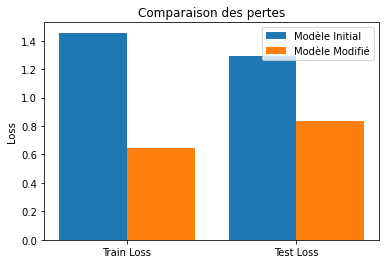

In [151]:
labels = ['Train Loss', 'Test Loss']
initial_losses = [loss_train, loss_test]
modified_losses = [loss_train_modified, loss_test_modified]

x = range(len(labels))
plt.bar(x, initial_losses, width=0.4, label='Modèle Initial', align='center')
plt.bar([p + 0.4 for p in x], modified_losses, width=0.4, label='Modèle Modifié', align='center')
plt.xticks([p + 0.2 for p in x], labels)
plt.ylabel('Loss')
plt.title('Comparaison des pertes')
plt.legend()
plt.show()

### 2. Régression logistique.

#### 2.1. Le jeu de données leaf.

Ce jeu de données a été recueilli en vue d'établir un lien entre un type d'architecture de feuilles d'arbre (orthotropic ou plagiotropic) à partir de caractéristiques mesurables de la feuille. 

Ces données sont contenues dans le fichier leafshape17.csv. En voici la description complète:


Le jeu de données leafshape17 data a 61 lignes and 8 colonnes dont

- bladelen: leaf length (in mm)

- petiole: a numeric vector

- bladewid: leaf width (in mm)

- latitude: latitude

- logwid: natural logarithm of width

- logpet: logarithm of petiole measurement

- loglen: logarithm of length

- arch: leaf architecture (0 = orthotropic, 1 = plagiotropic)

Référence:

King, D.A. and Maindonald, J.H. 1999. Tree architecture in relation to leaf dimensions and tree stature in temperate and tropical rain forests. Journal of Ecology 87: 1012-1024.

**Exercice** 

Importer ce jeu de données et en faire un dataset en Pytorch.

#### 2.2. Classification.

On fait la classification de ces données au moyen d'une régression logistique.

**Exercice**

1. Définir un réseau de neurones qui fait la classification de ces données
2. En faire l'apprentissage.
3. L'évaluer en calculant le nombre d'erreur de classification sur des données de test.
4. Etendre cette approche à un perceptron à deux couches.
5. Comparer les performances des deux modèles.